# License

MIT License

Copyright (c) 2021 garrett.harlow@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Setting up and Importing Functions

In [1]:
!pip install --upgrade dask lightgbm

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# set a random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast integer and float columns to save memory.
    """
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    float_cols = df.select_dtypes(include=['float64', 'float32']).columns

    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df


def add_lag_features(df: pd.DataFrame, lags, col_name: str) -> pd.DataFrame:
    """
    Create lag features for a given column (e.g., item_cnt_month).

    For each lag L in lags:
        col_name_lag_L is the value of col_name from L months before.
    """
    for lag in lags:
        shifted = df[['date_block_num', 'shop_id', 'item_id', col_name]].copy()
        shifted['date_block_num'] += lag
        shifted = shifted.rename(columns={col_name: f'{col_name}_lag_{lag}'})
        df = df.merge(
            shifted,
            on=['date_block_num', 'shop_id', 'item_id'],
            how='left'
        )
    return df


Reading in the Data

In [3]:
sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

sales = downcast_numeric(sales)
items = downcast_numeric(items)
shops = downcast_numeric(shops)
item_cats = downcast_numeric(item_cats)
test = downcast_numeric(test)

print('Sales shape (raw):', sales.shape)
print('Test shape:', test.shape)

Sales shape (raw): (2935849, 6)
Test shape: (214200, 3)


Cleaning the Data

In [4]:
sales = sales[sales['item_price'] > 0]
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)

Identifying Features of the Data

In [5]:
shops['city'] = shops['shop_name'].str.split().str[0]
shops['city_code'] = shops['city'].astype('category').cat.codes
shops_fe = shops[['shop_id', 'city_code']]

items_fe = items[['item_id', 'item_category_id']]

item_cats['type'] = item_cats['item_category_name'].str.split('-').str[0].str.strip()
item_cats['type_code'] = item_cats['type'].astype('category').cat.codes
item_cats_fe = item_cats[['item_category_id', 'type_code']]

Monthly Aggregation

In [6]:
monthly = (
    sales
    .groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
    .agg({
        'item_cnt_day': 'sum',
        'item_price': 'mean'
    })
)

monthly = monthly.rename(columns={
    'item_cnt_day': 'item_cnt_month',
    'item_price': 'avg_item_price'
})

print('Monthly aggregated shape:', monthly.shape)

Monthly aggregated shape: (1609124, 5)


Visualization of Distribution of Sales

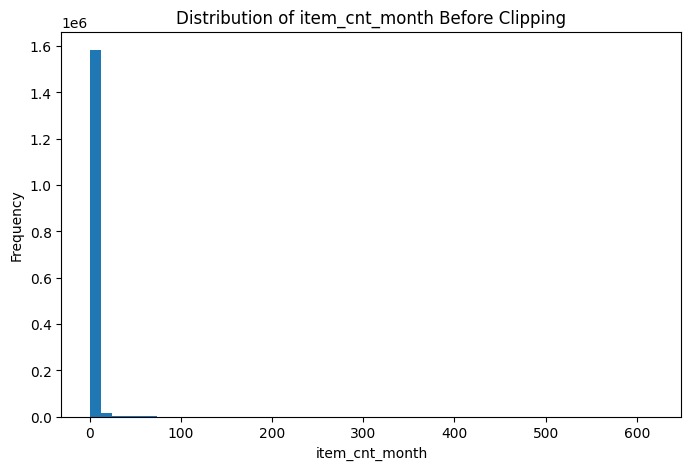

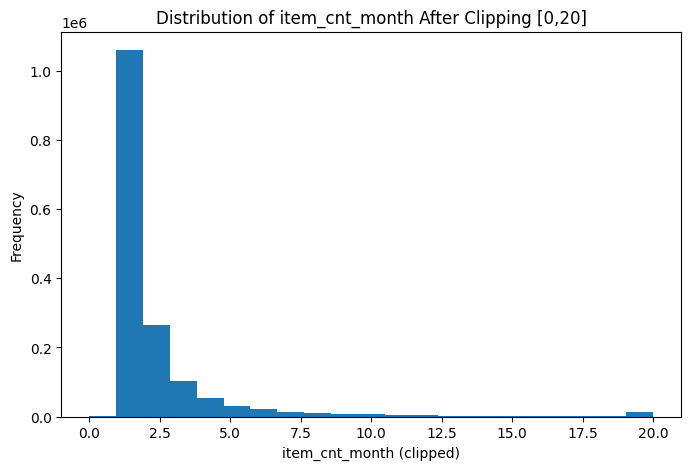

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(monthly['item_cnt_month'], bins=50)
plt.title('Distribution of item_cnt_month Before Clipping')
plt.xlabel('item_cnt_month')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
plt.hist(monthly['item_cnt_month'].clip(0,20), bins=21)
plt.title('Distribution of item_cnt_month After Clipping [0,20]')
plt.xlabel('item_cnt_month (clipped)')
plt.ylabel('Frequency')
plt.show()


Appending the Test Month

In [8]:
test_month = test[['shop_id', 'item_id']].copy()
test_month['date_block_num'] = 34          # one month beyond last training month
test_month['item_cnt_month'] = np.nan      # unknown target
test_month['avg_item_price'] = np.nan      # no price yet

data = pd.concat([monthly, test_month], ignore_index=True, sort=False)

/tmp/ipython-input-2260042822.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([monthly, test_month], ignore_index=True, sort=False)


Calendar

In [9]:
# date_block_num runs from 0 to 33 (train) and 34 (test)
data['month'] = data['date_block_num'] % 12
data['year'] = data['date_block_num'] // 12


Merging Features on the Dataset

In [10]:
data = data.merge(items_fe, on='item_id', how='left')
data = data.merge(item_cats_fe, on='item_category_id', how='left')
data = data.merge(shops_fe, on='shop_id', how='left')

Creating Different Monthly Means by Category

In [11]:
train_part = data[data['date_block_num'] < 34].copy()

#-- Monthly mean
item_month = (
    train_part
    .groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt_month']
    .mean()
    .rename(columns={'item_cnt_month': 'item_month_avg'})
)
data = data.merge(item_month, on=['date_block_num', 'item_id'], how='left')

#-- Monthly mean for shopping
shop_month = (
    train_part
    .groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt_month']
    .mean()
    .rename(columns={'item_cnt_month': 'shop_month_avg'})
)
data = data.merge(shop_month, on=['date_block_num', 'shop_id'], how='left')

#-- Monthly mean by category
cat_month = (
    train_part
    .groupby(['date_block_num', 'item_category_id'], as_index=False)['item_cnt_month']
    .mean()
    .rename(columns={'item_cnt_month': 'cat_month_avg'})
)
data = data.merge(cat_month, on=['date_block_num', 'item_category_id'], how='left')

item_price_overall = (
    train_part
    .groupby('item_id', as_index=False)['avg_item_price']
    .mean()
    .rename(columns={'avg_item_price': 'item_avg_price_overall'})
)
data = data.merge(item_price_overall, on='item_id', how='left')

#-- Comparing average price to overall price
data['price_delta'] = (
    (data['avg_item_price'] - data['item_avg_price_overall'])
    / data['item_avg_price_overall']
)
data['price_delta'] = data['price_delta'].replace([np.inf, -np.inf], np.nan)

data = downcast_numeric(data)

print('Data shape before lag features:', data.shape)

Data shape before lag features: (1823324, 15)


Shop Item Age

In [12]:
data = data.sort_values(['shop_id', 'item_id', 'date_block_num'])

data['shop_item_age'] = data.groupby(['shop_id', 'item_id']).cumcount()

data['shop_item_cum_cnt'] = (
    data.groupby(['shop_id', 'item_id'])['item_cnt_month']
        .cumsum()
        .shift(1)
)

data['shop_item_was_sold'] = (data['shop_item_cum_cnt'] > 0).astype('int8')


Adding in Time Lag Features

In [13]:
# Main target lags
TARGET_LAGS = [1, 2, 3, 6, 12]
data = add_lag_features(data, TARGET_LAGS, 'item_cnt_month')

# Short lags for aggregate & history features
AGG_LAGS = [1, 3]
for col in ['item_month_avg', 'shop_month_avg', 'cat_month_avg',
            'price_delta', 'shop_item_cum_cnt', 'shop_item_age']:
    data = add_lag_features(data, AGG_LAGS, col)

print('Data shape after all lag features:', data.shape)


Data shape after all lag features: (1823324, 35)


Preparing Final Train

In [14]:
train_full = data[data['date_block_num'] < 34].copy()
test_final = data[data['date_block_num'] == 34].copy()

train_df = train_full[train_full['date_block_num'] < 33].copy()
val_df = train_full[train_full['date_block_num'] == 33].copy()

TARGET_COL = 'item_cnt_month'
feature_cols = [c for c in train_df.columns if c != TARGET_COL]

X_train = train_df[feature_cols].fillna(0)
y_train = train_df[TARGET_COL].clip(0, 20)

X_val = val_df[feature_cols].fillna(0)
y_val = val_df[TARGET_COL].clip(0, 20)

X_test = test_final[feature_cols].fillna(0)

Training the Regression Model

In [15]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,     # smaller LR, more trees
    'num_leaves': 256,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'max_depth': -1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.3,
    'seed': RANDOM_SEED,
}

train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_val, label=y_val)

evals_result = {}

gbm = lgb.train(
    lgb_params,
    train_dataset,
    num_boost_round=3000,   # many rounds, but early stopping will cut it
    valid_sets=[train_dataset, valid_dataset],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.record_evaluation(evals_result),
        lgb.log_evaluation(period=100),
    ]
)

#-- Evaluate on validation set
val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE: {rmse_val:.4f}')

#-- Checking training RMSE
train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.738886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5467
[LightGBM] [Info] Number of data points in the train set: 1577593, number of used features: 34
[LightGBM] [Info] Start training from score 2.028159
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.61706	valid's rmse: 1.69055
[200]	train's rmse: 1.36439	valid's rmse: 1.45592
[300]	train's rmse: 1.28266	valid's rmse: 1.38158
[400]	train's rmse: 1.2431	valid's rmse: 1.35049
[500]	train's rmse: 1.21867	valid's rmse: 1.33556
[600]	train's rmse: 1.20082	valid's rmse: 1.32738
[700]	train's rmse: 1.18557	valid's rmse: 1.32165
[800]	train's rmse: 1.1729	valid's rmse: 1.31825
[900]	train's rmse: 1.16185	valid's rmse: 1.31564
[1000]	train's rmse: 1.15205	valid's rmse: 1.31271
[1100]	train's rmse: 1.14369	valid's rmse: 1.31041
[1200]	train's rmse: 1.13538	valid's rmse: 1

Example Item Forcast Visualization

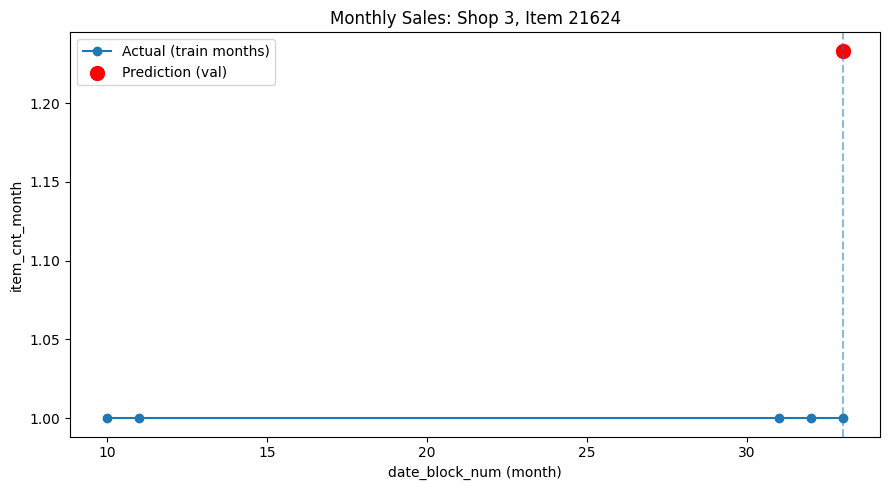

In [16]:
example_idx = val_df.sample(1, random_state=RANDOM_SEED).index[0]
example = val_df.loc[example_idx]

sid = int(example['shop_id'])
iid = int(example['item_id'])
val_month = int(example['date_block_num'])  # should be 33

# compute the model prediction  for this row
ex_features = X_val.loc[[example_idx]]  # keep as DataFrame with double brackets
pred_val = float(gbm.predict(ex_features, num_iteration=gbm.best_iteration)[0])

# get historical monthly actuals for that shop–item pair
series = monthly[(monthly['shop_id'] == sid) & (monthly['item_id'] == iid)] \
                .sort_values('date_block_num')

plt.figure(figsize=(9, 5))
plt.plot(series['date_block_num'], series['item_cnt_month'],
         marker='o', label='Actual (train months)')

# add the prediction point for the validation month
plt.scatter([val_month], [pred_val],
            color='red', s=100, label='Prediction (val)')
plt.axvline(val_month, linestyle='--', alpha=0.5)

plt.title(f'Monthly Sales: Shop {sid}, Item {iid}')
plt.xlabel('date_block_num (month)')
plt.ylabel('item_cnt_month')
plt.legend()
plt.tight_layout()
plt.show()

Prediction Error Distribution Visualization

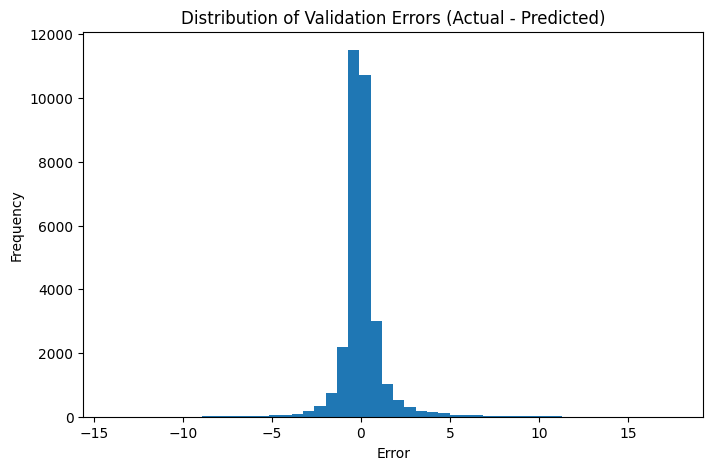

In [17]:
errors = y_val - val_pred

plt.figure(figsize=(8,5))
plt.hist(errors, bins=50)
plt.title('Distribution of Validation Errors (Actual - Predicted)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


Final Training of the Data

In [18]:
print('Train rows:', train_df.shape[0])
print('Validation rows:', val_df.shape[0])
print('Test rows:', test_final.shape[0])

X_train = downcast_numeric(X_train)
X_val = downcast_numeric(X_val)
X_test = downcast_numeric(X_test)

Train rows: 1577593
Validation rows: 31531
Test rows: 214200


LightGBM Learning Curve Visualization

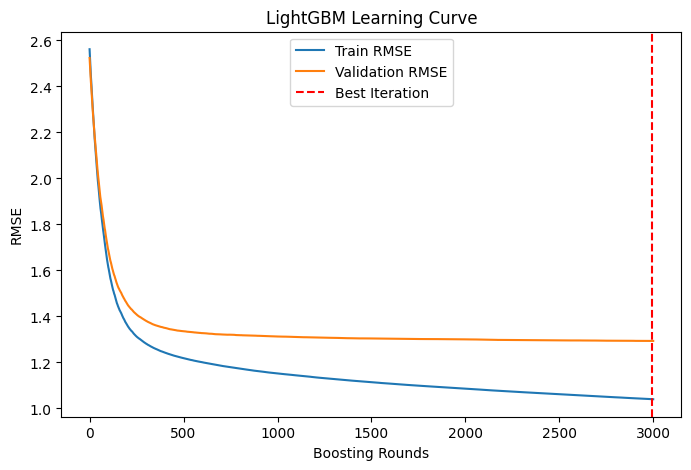

In [19]:
train_rmse_curve = evals_result['train']['rmse']
valid_rmse_curve = evals_result['valid']['rmse']

plt.figure(figsize=(8,5))
plt.plot(train_rmse_curve, label='Train RMSE')
plt.plot(valid_rmse_curve, label='Validation RMSE')
plt.axvline(gbm.best_iteration, linestyle='--', color='red', label='Best Iteration')
plt.title('LightGBM Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.legend()
plt.show()

Feature Importance

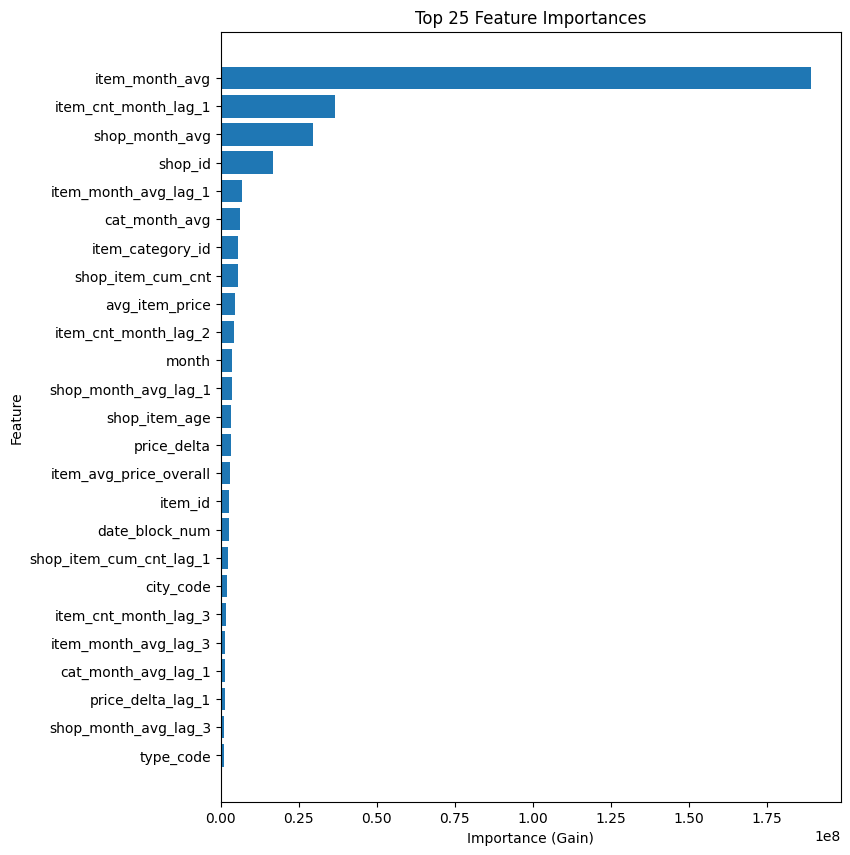

In [20]:
importances = gbm.feature_importance(importance_type='gain')
features = gbm.feature_name()

fi_df = pd.DataFrame({'feature': features, 'importance': importances}) \
         .sort_values('importance', ascending=False)

plt.figure(figsize=(8,10))
plt.barh(fi_df['feature'][:25][::-1], fi_df['importance'][:25][::-1])
plt.title('Top 25 Feature Importances')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.show()

Generating the Test Predictions

In [21]:
test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
test_pred = test_pred.clip(0, 20)

submission = sample_submission.copy()
submission['item_cnt_month'] = test_pred
submission.to_csv('submission_lightgbm.csv', index=False)

print('Saved submission_lightgbm.csv')

Saved submission_lightgbm.csv
